In [1]:
'''
    Creates predictions and labels across kfolds and stores
    them into ./testing/test_results/{Y_name}/ folder

    variables to change:
    * jsonpath - data path (in json format)
'''

'\n    Creates predictions and labels across kfolds and stores\n    them into ./testing/test_results/{Y_name}/ folder\n\n    variables to change:\n    * jsonpath - data path (in json format)\n'

In [2]:
import os
import pickle
import numpy as np
import keras
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

/home/dominykas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from EmbeddingModel import EmbeddingModel
from SimpleModel import SimpleModel
from CNNModel import CNNModel
from XGBoostModel import XGBoostModel

In [5]:
from testing.test_utils.data import createdata, get_class_weights
from testing.test_utils.classes import index2action, index2memory, index2splitting, index2xrootd
from testing.test_utils.classes import action_names,memory_names,splitting_names,xrootd_names
from testing.test_utils.plots import plot_models_results, plot_confusion_matrixes
from utils.metrics import normalized_confusion_matrix_and_identity_mse, \
                          recall, precision, conf_matrix

In [6]:
def save_hist(path, hist):
    ''' saves pickle file to path '''
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    pickle.dump(hist, open(path,'wb'))
    
def load_hist(path):
    ''' loads pickle file from path '''
    return pickle.load(open(path,'rb'))

# Creating data (all models, 5 folds, 200 epochs)

In [ ]:
def create_all_models_data_for_tensorboard():
    ''' creates results and stores them into ./testing/test_results/ directory
    '''
    jsonpath = './testing/test_data/history.180618.json'
    X,X_error_country_tier_positivity,Y_action,Y_memory,Y_splitting,Y_xrootd,Y_sites = createdata(jsonpath)
    Y_all = [Y_action,Y_memory,Y_splitting,Y_xrootd]
    print('{}: \t\t {}'.format('Y_all array length', len(Y_all)))

    for Y,Y_name in zip([Y_action,Y_xrootd,Y_splitting,Y_memory],['action','xrootd','splitting','memory']):
        num_classes = Y.shape[-1]
        Y = np.argmax(Y,axis=-1)

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        for Model,M_name in zip([SimpleModel,CNNModel,EmbeddingModel],['Simple','CNN','Embed']):
            for use_smote in [False,True]:
                for use_attention in [False,True]:

                    if use_attention == False and use_smote == False:
                        name = 'Simple'
                    if use_attention == True and use_smote == False:
                        if Model == XGBoostModel: continue
                        name = 'Att'
                    if use_attention == False and use_smote == True:
                        name = 'SMOTE'
                    if use_attention == True and use_smote == True:
                        if Model == XGBoostModel: continue
                        name = 'SMOTE_Att'

                    print('./testing/test_results/{}/{}_{}.pickle'.format(Y_name,M_name,name))
                    if os.path.exists('./testing/test_results/{}/{}_{}.pickle'.format(Y_name,M_name,name)):
                        print('file already exists... skipping...'); continue

                    if Model == EmbeddingModel:
                        m = Model(X,num_classes,add_attention=use_attention)
                    elif Model == XGBoostModel:
                        m = Model(num_classes)
                    else:
                        m = Model(num_classes,add_attention=use_attention)
                    hist = m.train( X_train, y_train, verbose=1, use_imblearn=use_smote, max_epochs=200, testing=True )

                    save_hist('./testing/test_results/{}/{}_{}.pickle'.format(Y_name,M_name,name), hist)

# Plotting results from created data (mse, recall, precision)

In [7]:
class EarlyStopping():
    ''' Same implementation as in ./utils/model_utils.py -> MultipleMetricsEarly Stopping
        Just not for keras (see details, explanations there)
    '''
    def __init__(self, patience=3, moving_avg_length=3, max_percentage_delta=0.2):
        self.best_scores = np.array([np.inf,-np.inf,-np.inf])
        self.is_better = np.array([np.less, np.greater, np.greater])
        self.moving_avg_length = moving_avg_length
        self.moving_avg_buffer = deque(maxlen=moving_avg_length)
        self.importance = max_percentage_delta
        self.patience = patience
        self.wait = 0
        self.stop = False

    def append(self, conf_mse, recall, precision):
        current_scores = np.array([conf_mse, recall, precision])
        self.moving_avg_buffer.append( current_scores )
        if len(self.moving_avg_buffer) != self.moving_avg_length:
            scores = current_scores
        else:
            scores = np.mean(self.moving_avg_buffer, axis=0)
        bool_arr = np.array([ is_btr(s,b) for s,b,is_btr in zip(scores,self.best_scores,self.is_better) ])
        percentage_increase = (scores[0] - self.best_scores[0]) / self.best_scores[0]

        # see if atleast one is getting better
        if len(bool_arr[ bool_arr == True ])/len(bool_arr) != 0:
            self.wait = 0
            self.best_scores[ bool_arr ] = scores[ bool_arr ]
        else:
            self.wait += 1

        # see if waiting is bigger then patience
        if self.wait > self.patience:
            self.stop = True

        # see if main metric is not getting worse more then some percentage number self.importance
        first_metric_is_getting_worse = not self.is_better[0]( percentage_increase, 0 )
        percentage_is_bigger_then_importance = np.greater( np.abs(percentage_increase), self.importance )
        if first_metric_is_getting_worse and percentage_is_bigger_then_importance:
            self.stop = True

In [8]:
def val_results_on_earlystopping():
    for dataset_name,classes in zip(['action','memory','splitting','xrootd'],
                                    [action_names,memory_names,splitting_names,xrootd_names]):
        dataset_path = os.path.join('./testing/test_results/',dataset_name)
#         paths = [ a.path for a in os.scandir(dataset_path) ]
        paths = [ a.path for a in os.scandir(dataset_path) if not 'Att' in a.name ]
        names = [ p.split('/')[-1][:-7] for p in paths ]
        val_models = { n:load_hist(p) for n,p in sorted(zip(names,paths)) }

        plot_models_results( val_models, classes, early_stopping_class=EarlyStopping, 
                             plot_title='{} dataset'.format(dataset_name))

/home/dominykas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


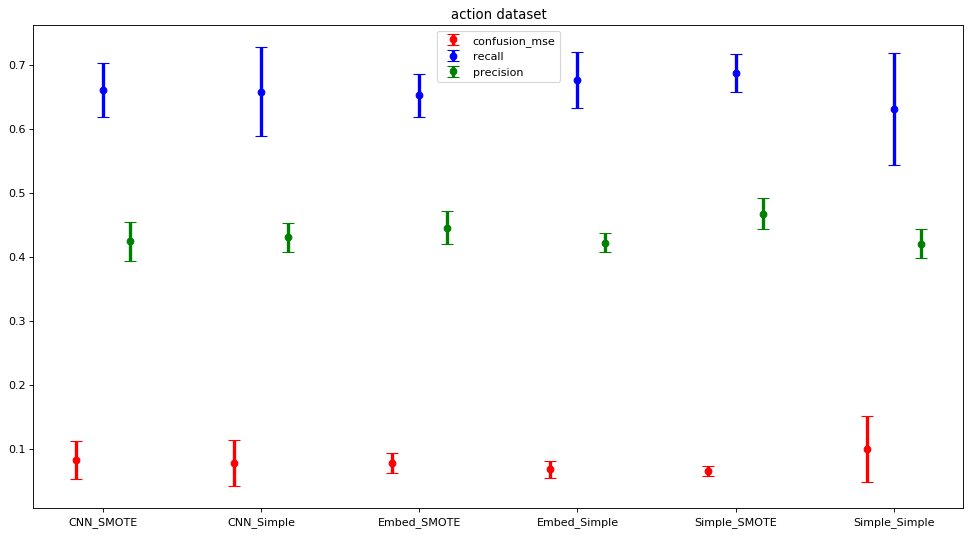

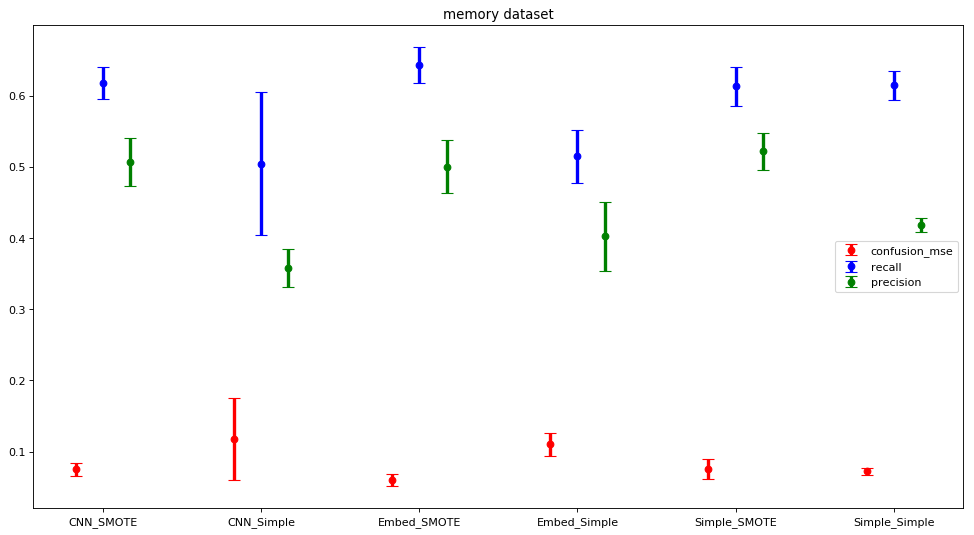

/home/dominykas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


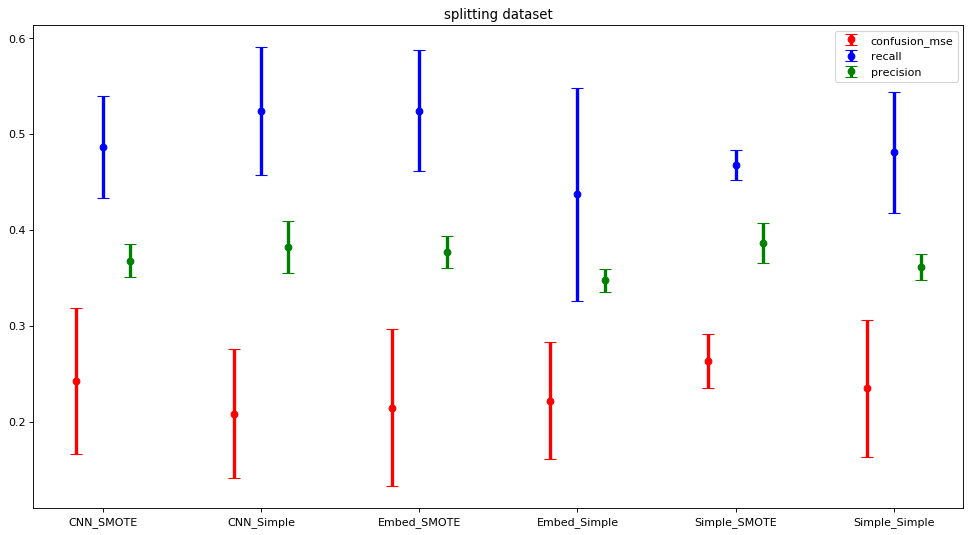

/home/dominykas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/dominykas/Desktop/GitHub/OperatorActionPredictionPrev/prediction_models/testing/test_utils/plots.py:165: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
/home/dominykas/Desktop/GitHub/OperatorActionPredictionPrev/prediction_models/testing/test_utils/plots.py:149: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


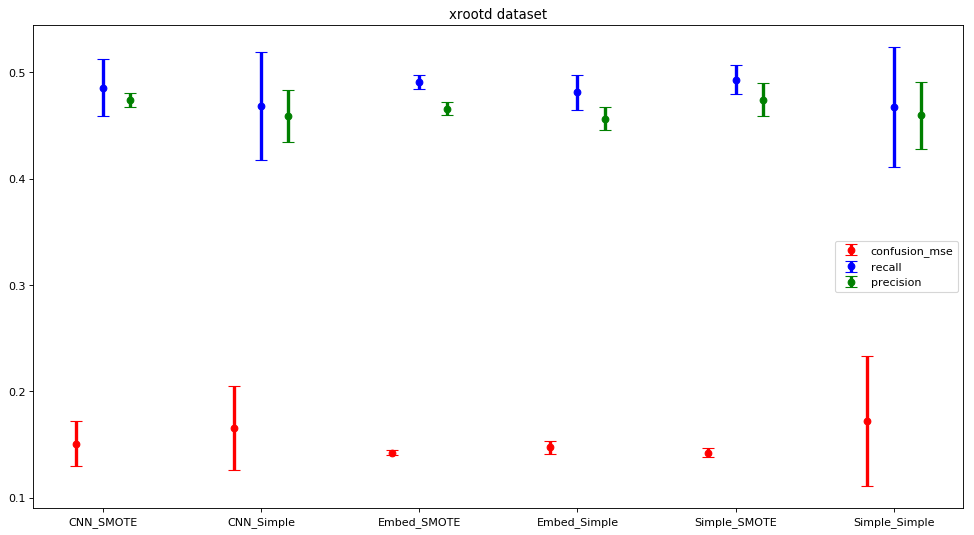

In [9]:
val_results_on_earlystopping()

# Plotting confusion matrix from created data

In [ ]:
class EarlyStopping():
    ''' Same implementation as in ./utils/model_utils.py -> MultipleMetricsEarly Stopping
        Just not for keras (see details, explanations there)
    '''
    def __init__(self, patience=3, moving_avg_length=3, max_percentage_delta=0.2):
        self.best_scores = np.array([np.inf,-np.inf,-np.inf])
        self.is_better = np.array([np.less, np.greater, np.greater])
        self.moving_avg_length = moving_avg_length
        self.moving_avg_buffer = deque(maxlen=moving_avg_length)
        self.importance = max_percentage_delta
        self.patience = patience
        self.wait = 0
        self.stop = False

    def append(self, conf_mse, recall, precision):
        current_scores = np.array([conf_mse, recall, precision])
        self.moving_avg_buffer.append( current_scores )
        if len(self.moving_avg_buffer) != self.moving_avg_length:
            scores = current_scores
        else:
            scores = np.mean(self.moving_avg_buffer, axis=0)
        bool_arr = np.array([ is_btr(s,b) for s,b,is_btr in zip(scores,self.best_scores,self.is_better) ])
        percentage_increase = (scores[0] - self.best_scores[0]) / self.best_scores[0]

        # see if atleast one is getting better
        if len(bool_arr[ bool_arr == True ])/len(bool_arr) != 0:
            self.wait = 0
            self.best_scores[ bool_arr ] = scores[ bool_arr ]
        else:
            self.wait += 1

        # see if waiting is bigger then patience
        if self.wait > self.patience:
            self.stop = True

        # see if main metric is not getting worse more then some percentage number self.importance
        first_metric_is_getting_worse = not self.is_better[0]( percentage_increase, 0 )
        percentage_is_bigger_then_importance = np.greater( np.abs(percentage_increase), self.importance )
        if first_metric_is_getting_worse and percentage_is_bigger_then_importance:
            self.stop = True

In [16]:
def conf_matrix_on_earlystopping():
    for dataset_name,classes in zip(['action','memory','splitting','xrootd'],
                                    [action_names,memory_names,splitting_names,xrootd_names]):
        dataset_path = os.path.join('./testing/test_results/',dataset_name)
#         paths = [ a.path for a in os.scandir(dataset_path) ]
        paths = [ a.path for a in os.scandir(dataset_path) if not 'Att' in a.name ]
        names = [ p.split('/')[-1][:-7] for p in paths ]
        val_models = { n:load_hist(p) for n,p in sorted(zip(names,paths)) }
        print('\n\n!!! {} dataset !!!\n\n'.format(dataset_name))
        plot_confusion_matrixes( val_models, classes, early_stopping_class=EarlyStopping)



!!! action dataset !!!




/home/dominykas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


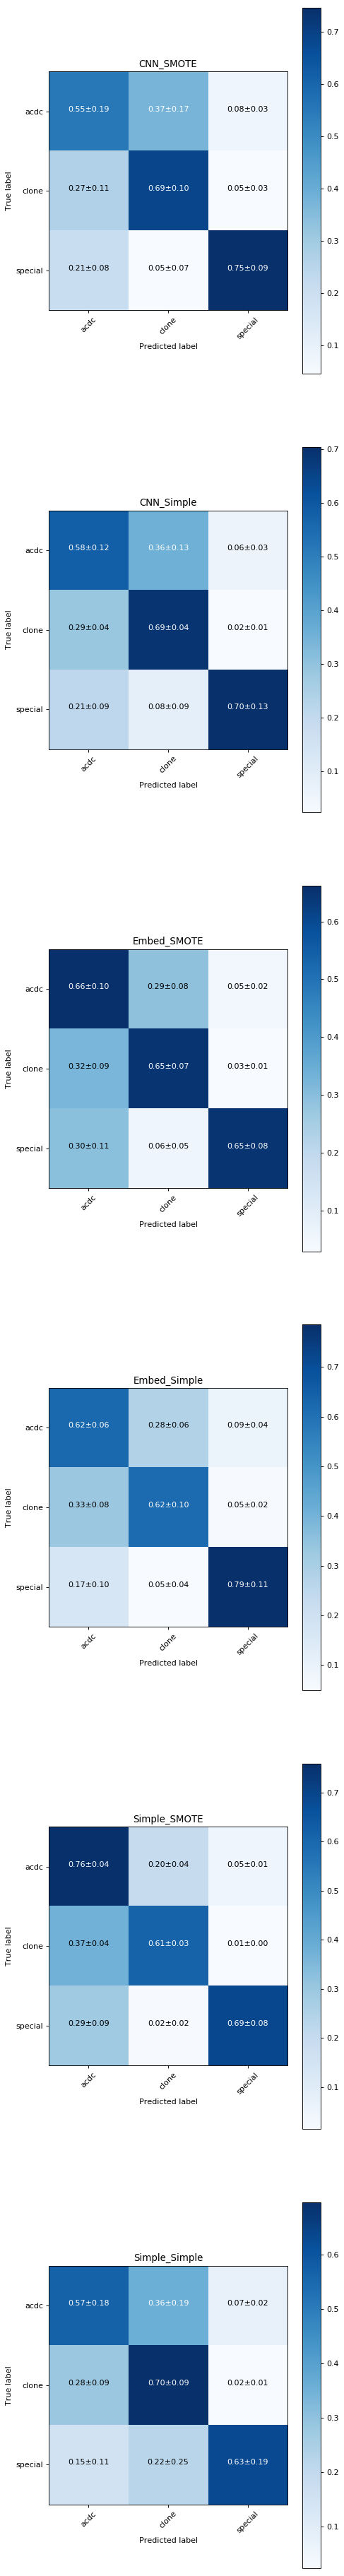



!!! memory dataset !!!




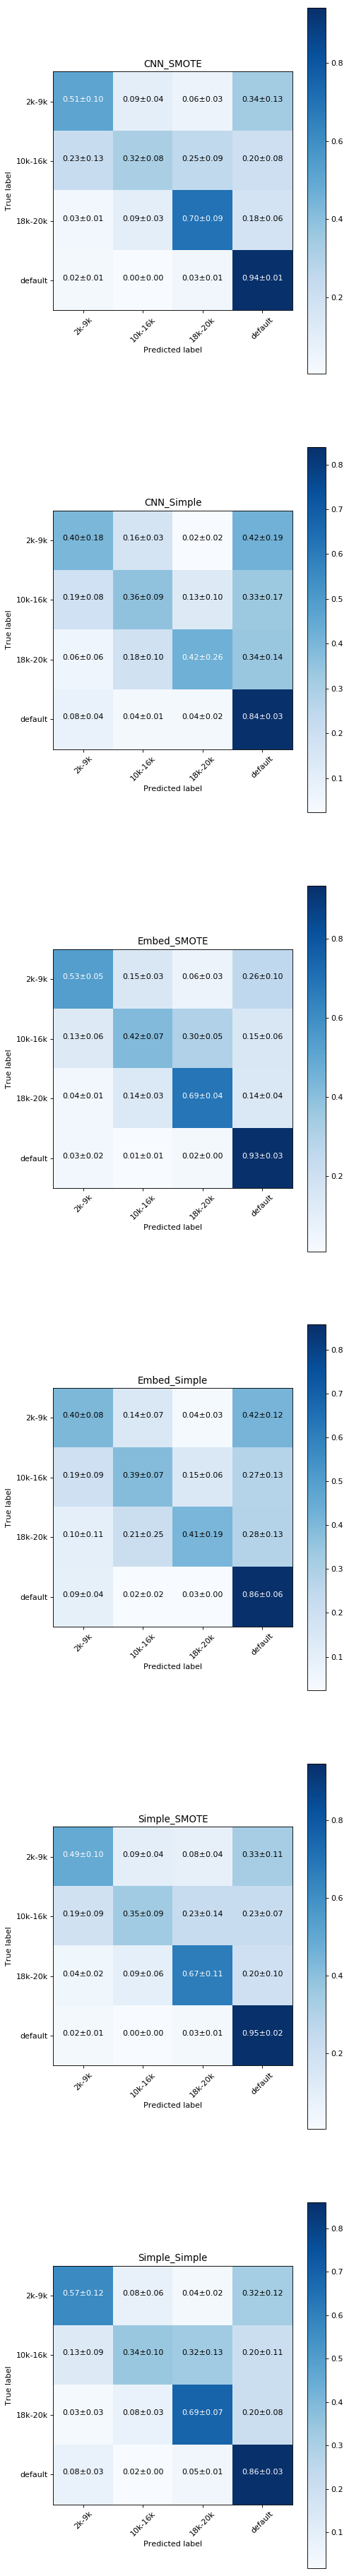



!!! splitting dataset !!!




/home/dominykas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


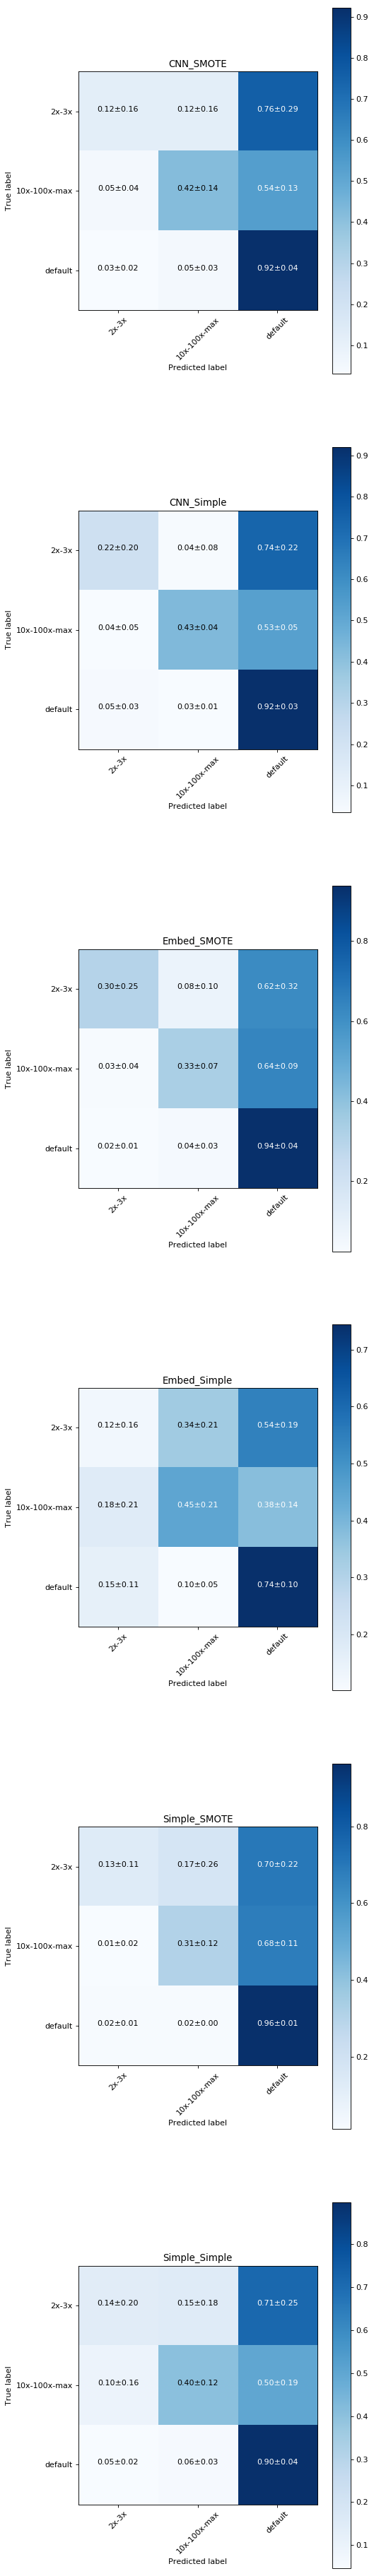



!!! xrootd dataset !!!




/home/dominykas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/dominykas/Desktop/GitHub/OperatorActionPredictionPrev/prediction_models/testing/test_utils/plots.py:165: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
/home/dominykas/Desktop/GitHub/OperatorActionPredictionPrev/prediction_models/testing/test_utils/plots.py:149: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


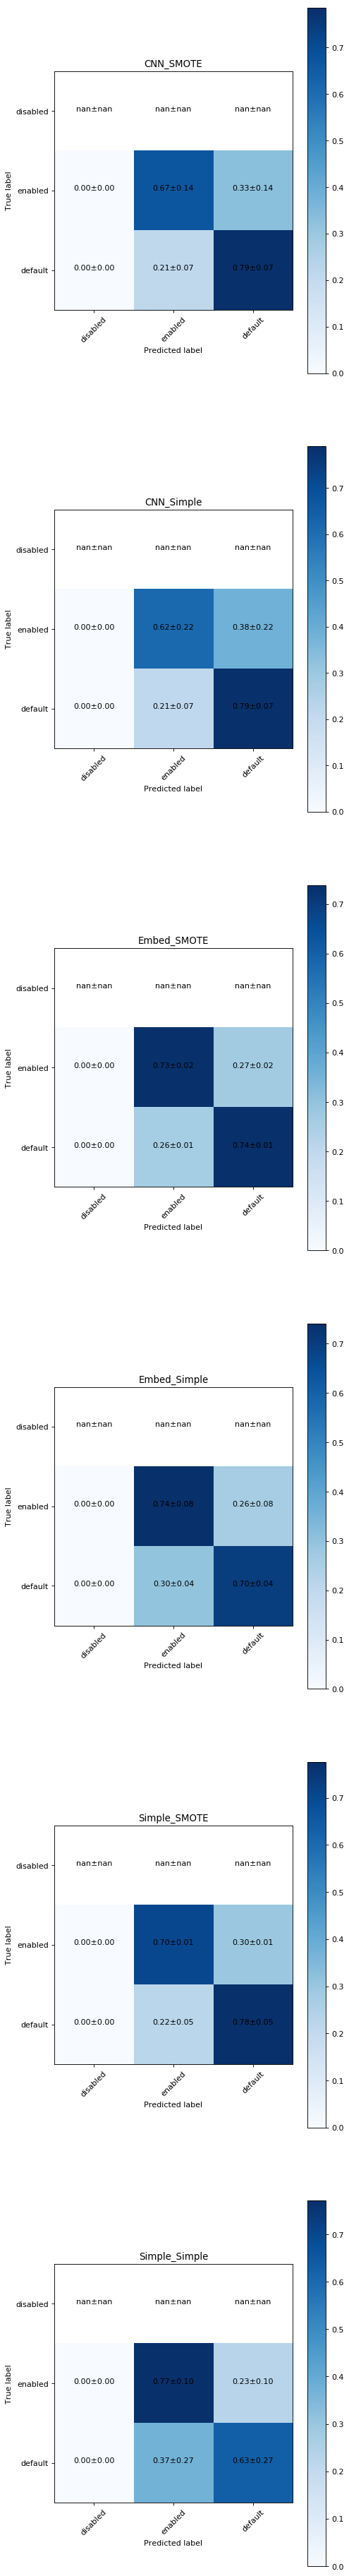

In [17]:
conf_matrix_on_earlystopping()

# Creating test results (w/ early stop and store results into csv)

In [ ]:
def create_test_results():
    ''' splits data into train, test, trains on train data with early stopping
        and saves all results into ./testing/test_results/results.csv
    '''
    with open('./testing/test_results/results.csv','w') as f:
        f.write('model_name,num_trained_epochs,min_score,argmin_score,macro_recall,macro_precision,confusion_mse\n')
    
    def evaluate(y_test,y_pred,num_classes):
        y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)
        y_pred = keras.utils.to_categorical(y_pred, num_classes=num_classes)
        r = recall(average='macro')(y_test,y_pred)
        p = precision(average='macro')(y_test,y_pred)
        n = normalized_confusion_matrix_and_identity_mse()(y_test,y_pred)
        cm = conf_matrix()(y_test,y_pred)
        return r,p,n,cm

    jsonpath = './testing/test_data/history.180618.json'
    X,X_error_country_tier_positivity,Y_action,Y_memory,Y_splitting,Y_xrootd,Y_sites = createdata(jsonpath)
    Y_all = [Y_action,Y_memory,Y_splitting,Y_xrootd]
    print('{}: \t\t {}'.format('Y_all array length', len(Y_all)))

    for Y,Y_name in zip([Y_action,Y_splitting,Y_xrootd,Y_memory],['action','splitting','xrootd','memory']):
        num_classes = Y.shape[-1]
        Y = np.argmax(Y,axis=-1)

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        for Model,M_name in zip([SimpleModel,CNNModel,EmbeddingModel,XGBoostModel],['Simple','CNN','Embed','XGBoost']):
            for use_smote in [False]:
                for use_attention in [False,True]:

                    if use_attention == False and use_smote == False:
                        name = 'Simple'
                    if use_attention == True and use_smote == False:
                        if Model == XGBoostModel: continue
                        name = 'Att'
                    if use_attention == False and use_smote == True:
                        name = 'SMOTE'
                    if use_attention == True and use_smote == True:
                        if Model == XGBoostModel: continue
                        name = 'SMOTE_Att'
                    
                    print('\n{}/{}_{}.pickle\n'.format(Y_name, M_name, name))
                    
                    if Model == EmbeddingModel:
                        m = Model(X,num_classes,add_attention=use_attention)
                    elif Model == XGBoostModel:
                        m = Model(num_classes)
                    else:
                        m = Model(num_classes,add_attention=use_attention)

                    hist = m.train( X_train, y_train, verbose=1, use_imblearn=use_smote )

                    if use_attention:
                        y_pred = m.predict(X_test)[0]
                    else:
                        y_pred = m.predict(X_test)
                    
                    e = evaluate(y_test,y_pred,num_classes)
                    
                    num_epochs = len(hist['loss'])

                    min_score = np.min(hist['main_score'])
                    argmin = np.argmin(hist['main_score'])

                    with open('./testing/test_results/results.csv','a') as f:
                        f.write('{}/{}_{}.pickle,{},{},{},{:.3},{:.3},{:.3},{}\n'.format(
                            Y_name, M_name, name, str(num_epochs), min_score, argmin, 
                            e[0], e[1], e[2], str( e[3].tolist() )))
                        # to get back from string use eval(str(a.tolist()))